In [1]:
# IMPORT ALL THE LIBRARIES USED IN THE NOTEBOOK
import math
import plotly.subplots as psu
import matplotlib.pyplot as plt

from waffles.data_classes.WaveformSet import WaveformSet


In [16]:
runnumber = 29174
from waffles.input.pickle_file_to_WaveformSet import pickle_file_to_WaveformSet

file = f'/eos/home-h/hvieirad/waffles/analysis/rawdata/waffles_tau_slow_protoDUNE_HD/wfset_run0{runnumber}.pkl'

wfset = pickle_file_to_WaveformSet(file)


In [26]:
from waffles.data_classes.Waveform import Waveform
from waffles.utils.denoising.tv1ddenoise import Denoise
import numpy as np
import ctypes

import yaml

with open('cuts_template.yaml', 'r') as f:
    cutsdata = yaml.safe_load(f)


binsbase = np.linspace(0,2**14-1,2**14)
times = np.linspace(0, 1024, 1024, endpoint=False)
threshold = 6
wait = 25
baselinefinish = 112
npts = wfset.points_per_wf


denoiser = Denoise()
def filter_waveform(wvf: Waveform.adcs, filter:int = 2, npoints:int = npts):
    response = denoiser.apply_denoise(wvf, filter)
    return response
def compute_base_mean(wvf: Waveform.adcs, res0:int) -> tuple[float, bool]:
    minimumfrac = 1/6.
    i = 0
    res = 0
    counts = 0
    for _ in wvf:
        if (i>=baselinefinish):
            break
        val = wvf[i]
        if ((val > res0+threshold) | (val < res0 - threshold)):
            i+=wait
        else:
            res+=val
            counts+=1
            i+=1
    if (counts>0):
        res /= counts
    if(counts > baselinefinish*minimumfrac):
        return res, True
    else:
        return res0, False
            
def compute_baseline(wvf_base: Waveform.adcs) -> tuple[float, bool]:
    # # find the MPV so we can estimate the offset
    hist, bin_edges = np.histogram(wvf_base, bins=binsbase)
    # first estimative of baseline
    res0 = bin_edges[np.argmax(hist)]
    return compute_base_mean(wvf_base, res0)
    
    
def wfset_baseline(waveform: Waveform) -> tuple[float, bool]:
    wvf: Waveform.adcs = waveform.adcs
    response = filter_waveform(wvf,2)
    wvf_base = response[0:baselinefinish]
    res0, optimal = compute_baseline(wvf_base)
    waveform.filtered = response

    # now check each cross point with the threshold
    # idx_cross_t = np.where(wvf_base[1:] >= res0 + threshold & wvf_base[:-1] <= res0 + threshold)
    return res0, optimal

def applycuts(waveform: Waveform, ch:int) -> bool:
    try:
        cuts = cutsdata[ch]['cuts']
    except Exception as error:
        # print('Yo... you forgot to add cuts for this channel')
        # print(error)
        return True
    for cut in cuts:
        t0 = cut['t0']
        tf = cut['tf']
        thre = cut['threshold']
        cuttype = cut['type']
        filter = cut['filter']
        stop = cut['stop']
        wvfcut = filter_waveform((waveform.adcs-waveform.baseline), filter)*(-1)
        refval = wvfcut[t0:tf].max()
        if cuttype == 'higher':
            if refval < thre:
                return False
        elif cuttype =='lower':
            if refval > thre:
                return False
        if stop:
            break
    return True
        
        
    

def allow_certain_endpoints_channels(waveform: Waveform, allowed_endpoints:list, allowed_channels:list) -> bool:
    # if int(abs(int(int(Waveform.timestamp)-int(ts_mid)))) < 200000000:
    if waveform.endpoint in allowed_endpoints:
        if waveform.channel in allowed_channels:
            # if waveform.record_number > 10:
            #     return False
            base, optimal = wfset_baseline(waveform)
            waveform.baseline = base
            waveform.optimal = optimal
            if not optimal: return False
            outcuts = applycuts(waveform, waveform.channel)
            if outcuts:
                return True
    return False


In [29]:
with open('cuts_template.yaml', 'r') as f:
    cutsdata = yaml.safe_load(f)
wfset_ch = WaveformSet.from_filtered_WaveformSet( wfset, allow_certain_endpoints_channels, [112] , [11225])
len(wfset_ch.waveforms)


60499

(100.0, 200.0)

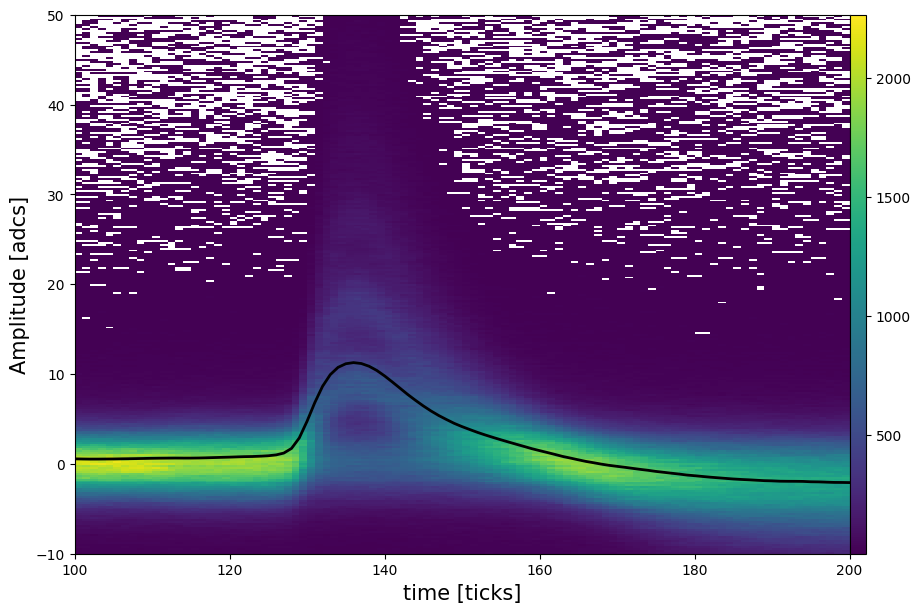

In [30]:
import pickle
time_arrays = np.tile(times, (len(wfset_ch.waveforms), 1))
wvf_arrays = np.array([denoiser.apply_denoise((waveform.adcs.astype(np.float32) - waveform.baseline)*-1,2) for waveform in wfset_ch.waveforms])


h, yedges, xedges = np.histogram2d(wvf_arrays.flatten(), time_arrays.flatten(), bins=(280,1024), range = [[-10,50],[0,1024]])
h[h==0] = np.nan
fig, ax = plt.subplots(1, 1, figsize=(10,7))

x, y = np.meshgrid(xedges, yedges)
pcm = ax.pcolormesh(x, y, h)
ax.set_ylabel("Amplitude [adcs]", fontsize=15)
ax.set_xlabel("time [ticks]", fontsize=15)
cax = ax.inset_axes([1.001, 0., 0.02, 1.])
plt.colorbar(pcm, ax=ax, cax=cax)

avgwvf = np.mean(wvf_arrays, axis=0)
res0, status = compute_baseline(avgwvf[:112])
avgwvf-=res0
plt.plot(avgwvf, '-k', lw=2)
wfset_ch.avgwvf = avgwvf
plt.xlim(100,200)
# pickleavgname = f'templates/template_run0{runnumber}.pkl'
# with open(pickleavgname, "wb") as f:
#     pickle.dump(wfset_ch, f)


In [13]:
mchannels = {}
for w in wfset.waveforms:
    w:Waveform
    if w.channel in mchannels.keys():
        mchannels[w.channel] += 1
    else:
        mchannels[w.channel] = 0
mchannels


{np.uint16(11326): 8589,
 np.uint16(11327): 8319,
 np.uint16(11330): 8342,
 np.uint16(11331): 8327,
 np.uint16(11332): 8291,
 np.uint16(11333): 8251,
 np.uint16(11334): 8320,
 np.uint16(11335): 8330,
 np.uint16(11336): 8268,
 np.uint16(11337): 8308,
 np.uint16(11340): 8306,
 np.uint16(11341): 8329,
 np.uint16(11300): 8607,
 np.uint16(11301): 8822,
 np.uint16(11302): 9062,
 np.uint16(11303): 9365,
 np.uint16(11304): 9610,
 np.uint16(11305): 9810,
 np.uint16(11306): 10025,
 np.uint16(11307): 10248,
 np.uint16(11310): 10443,
 np.uint16(11311): 10653,
 np.uint16(11312): 10884,
 np.uint16(11313): 11163,
 np.uint16(11314): 10845,
 np.uint16(11315): 10642,
 np.uint16(11316): 10445,
 np.uint16(11317): 10178,
 np.uint16(11320): 9864,
 np.uint16(11321): 9657,
 np.uint16(11322): 9499,
 np.uint16(11323): 9246,
 np.uint16(11324): 9045,
 np.uint16(11325): 8812,
 np.uint16(11342): 8319,
 np.uint16(11343): 8304,
 np.uint16(11225): 8829,
 np.uint16(11226): 8585,
 np.uint16(11227): 8322,
 np.uint16(1123

In [7]:
validbases = {True:0, False:0}
for w in wfset_ch.waveforms:
    w:Waveform
    validbases[w.optimal]+=1
validbases

{True: 5562, False: 0}

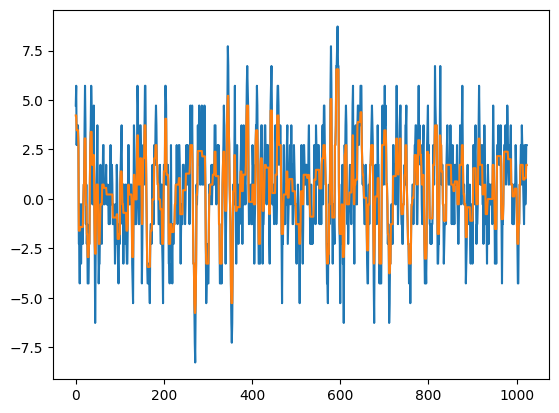

In [8]:
wvftest = wfset_ch.waveforms[0]

plt.plot((wvftest.adcs-wvftest.baseline)*-1)
plt.plot((wvftest.filtered-wvftest.baseline)*-1)
